In [1]:
# Imports
import pandas
import numpy as np

import random
import ast

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

# Prepare data

In [5]:
# ?/?/99 -> 1999
# ?/?/10 -> 2010
def GetReleaseYear(orig):
    if pandas.isna(orig):
        return 1900
    yr = int(orig.split('/')[2])
    if yr <= 19:
        return 2000 + yr
    else:
        return 1900 + yr

def GetReleaseDOW(inp):
    import datetime
    if pandas.isna(inp):
        return -1
    month, date, year = map(int, inp.split('/'))
    if year < 20:
        year = 2000 + year
    else:
        year = 1900 + year
    return datetime.datetime(year, month, date).weekday()

K_DATE_RANGES = ['1-5', '6-10', '11-15', 
                 '16-20', '21-25', '26-31']
def GetReleaseDateRange(inp):
    if pandas.isna(inp):
        return 0
    date = int(inp.split('/')[1])
    if date <= 5:
        return '1-5'
    if date <= 10:
        return '6-10'
    if date <= 15:
        return '11-15'
    if date <= 20:
        return '16-20'
    if date <= 25:
        return '21-25'
    return '26-31'

# xx/?/? -> xx
def GetReleaseMonth(orig):
    if pandas.isna(orig):
        return 0
    return int(orig.split('/')[0])
# '{..}' -> {..}
def GetDictionary(s):
    try:
        d = ast.literal_eval(s)
    except ValueError as err:
        if not pandas.isna(s):
            print("get_dictionary error: {}".format(err))
        d = {}    
    return d

def GetCountryCodes(raw):
    return [x.get('iso_3166_1', 'NA').lower() for x in GetDictionary(raw)]

def GetGenres(raw):
    return [x.get('name', 'NA').lower() for x in GetDictionary(raw)]

def GetProductionCompanies(raw):
    return [x.get('name', 'NA').lower().replace(' ', '_')
            for x in GetDictionary(raw)]

# Holder for state needed to convert raw data to 
# sample that can be used for prediction.
class TransformerState:
    def __init__(self):
        pass
    
def TransformAndFix(train, test):
    t_production_countries = train['production_countries'].apply(GetCountryCodes)
    t_genres = train['genres'].apply(GetGenres)    
    t_production_companies = train['production_companies'].apply(GetProductionCompanies)
    ret = TransformerState()
    ret.genres = pandas.Series(t_genres.sum()).value_counts()
    ret.countries = pandas.Series(t_production_countries.sum()).value_counts()
    ret.production_companies = pandas.Series(t_production_companies.sum()).value_counts()
    
    ret.genres = ret.genres[ret.genres > 50]
    ret.countries = ret.countries[ret.countries > 10]
    ret.production_companies = ret.production_companies[ret.production_companies > 10]

    for data in [train, test]:
        data['t_release_yr'] = data['release_date'].apply(GetReleaseYear)
        data['t_release_mo'] = data['release_date'].apply(GetReleaseMonth)
        for comp in ret.production_companies.keys():
            data['t_production_company_{}'.format(comp)] = \
                data['production_companies'].apply(lambda x: comp in GetProductionCompanies(x))

        for g in ret.genres.keys():
            data['t_genre_{}'.format(g)] = \
                data['genres'].apply(lambda x: g in GetGenres(x))
        for c in ret.countries.keys():
            data['t_production_country_{}'.format(c)] = \
                data['production_countries'].apply(lambda x: c in GetCountryCodes(x))
        for dow in range(7):
            data['t_dow_{}'.format(dow)] = \
                data['release_date'].apply(lambda x: dow == GetReleaseDOW(x))
        for date_range in K_DATE_RANGES:
            data['t_date_range_{}'.format(dow)] = \
                data['release_date'].apply(lambda x: date_range == GetReleaseDateRange(x))
    return ret

In [6]:
train_orig = pandas.read_csv('data/train.csv')
test_orig = pandas.read_csv('data/test.csv')

train = train_orig.copy()
test = test_orig.copy()

In [7]:
transformer_state = TransformAndFix(train, test)

In [21]:
cols_to_skip = {'id', 'belongs_to_collection', 'genres', 'homepage',
             'imdb_id', 'original_language', 'original_title', 'overview',
             'production_companies', 'production_countries', 'release_date', 
             'runtime', 'spoken_languages', 'status', 'tagline', 'title', 
             'Keywords', 'cast', 'crew', 'poster_path', 'revenue'}
t_date_range_cols = {c for c in train.columns if c.startswith('t_date_range_')}
# useful_columns = [c for c in train.columns if c not in cols_to_skip ]
useful_columns = [c for c in train.columns if c not in cols_to_skip and c not in t_date_range_cols]

In [9]:
train[useful_columns].head()

,budget,popularity,t_release_yr,t_release_mo,t_production_company_warner_bros.,t_production_company_universal_pictures,t_production_company_paramount_pictures,t_production_company_twentieth_century_fox_film_corporation,t_production_company_columbia_pictures,t_production_company_metro-goldwyn-mayer_(mgm),...,t_production_country_dk,t_production_country_br,t_dow_0,t_dow_1,t_dow_2,t_dow_3,t_dow_4,t_dow_5,t_dow_6,t_date_range_6
0,14000000,6.575393,2015,2,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,40000000,8.248895,2004,8,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,3300000,64.299990,2014,10,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,1200000,3.174936,2012,3,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,1.148070,2009,2,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [10]:
test[useful_columns].head()

,budget,popularity,t_release_yr,t_release_mo,t_production_company_warner_bros.,t_production_company_universal_pictures,t_production_company_paramount_pictures,t_production_company_twentieth_century_fox_film_corporation,t_production_company_columbia_pictures,t_production_company_metro-goldwyn-mayer_(mgm),...,t_production_country_dk,t_production_country_br,t_dow_0,t_dow_1,t_dow_2,t_dow_3,t_dow_4,t_dow_5,t_dow_6,t_date_range_6
0,0,3.851534,2007,7,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,88000,3.559789,1958,5,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0,8.085194,1997,5,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,6800000,8.596012,2010,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2000000,3.217680,2005,2,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Training

In [11]:
# Rmse.
def Score(actual, predicted):
    return np.sqrt(mean_squared_error(actual,  predicted))

# Returns log(revenue).
def GetY(data):
    return np.log1p(data["revenue"])

# - Splits the training data to n_splits
# - Fits the given model using each of the split as validation set and
#   the rest as training set. So it trains n_splits models
# - Predictions of the resultant model will be avegage of these n_splits
#   models
class KFoldValidationLearner():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for train_ids, validation_ids in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].isin(unique_vis[train_ids])],
                    ids[data['id'].isin(unique_vis[validation_ids])]
                ])
            
    def Learn(self, train, test,
              features, y_column,
              model, name,
              fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        full_score = 0
        test[name] = 0
        train[name] = np.NaN
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            # Prepare training and validation data.
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train[y_column].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train[y_column].iloc[val])
            # Train the model.
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            # Compute feature importance.
            if len(model.feature_importances_) != 0:
                model.FI = pandas.DataFrame(index=features)
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            # Update predictions.
            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            test_predictions = model.predict(test[features])
            test_predictions[test_predictions < 0] = 0
            # Compute error using cross validaiton set.
            fold_score = Score(y_valid, predictions)
            full_score += fold_score / len(self.fold_ids)
            train[name].iloc[val] = predictions
            test[name] += test_predictions / len(self.fold_ids)
            print("Fold: ", fold_id, " Error: ", fold_score)
                
        print("Final score: ", full_score)
        return full_score

In [12]:
xgbmodel = xgb.XGBRegressor(max_depth=5, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=random.randint(0, 10000),
                            silent=True,
                            subsample=0.8, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)

catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=random.randint(0, 10000))

lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random.randint(0, 10000), 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [13]:
kfold_learner = KFoldValidationLearner(train, 5)
kfold_learner.Learn(train, test, useful_columns, "revenue", xgbmodel, name="xgb")

[0]	validation_0-rmse:15.5725
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.11919
[200]	validation_0-rmse:3.11428
[300]	validation_0-rmse:2.43072
[400]	validation_0-rmse:2.31168
[500]	validation_0-rmse:2.2875
[600]	validation_0-rmse:2.27501
[700]	validation_0-rmse:2.26799
[800]	validation_0-rmse:2.26191
[900]	validation_0-rmse:2.25862
[1000]	validation_0-rmse:2.25376
[1100]	validation_0-rmse:2.25169
[1200]	validation_0-rmse:2.25022
[1300]	validation_0-rmse:2.24783
[1400]	validation_0-rmse:2.24791
[1500]	validation_0-rmse:2.2466
[1600]	validation_0-rmse:2.24645
[1700]	validation_0-rmse:2.24555
[1800]	validation_0-rmse:2.24266
[1900]	validation_0-rmse:2.2398
[2000]	validation_0-rmse:2.2381
[2100]	validation_0-rmse:2.23663
[2200]	validation_0-rmse:2.23613
[2300]	validation_0-rmse:2.23637
[2400]	validation_0-rmse:2.23581
[2500]	validation_0-rmse:2.23655
[2600]	validation_0-rmse:2.23761
[2700]	validation_0-rmse:2.23757
[2800]	validation_0-rmse:2.23705
Stopping. Best iteration:
[2398]	validation_0-rmse:2.23566

Fold:  0  Error:  2.235657622

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.06413
[200]	validation_0-rmse:2.97326
[300]	validation_0-rmse:2.21155
[400]	validation_0-rmse:2.07257
[500]	validation_0-rmse:2.05096
[600]	validation_0-rmse:2.04674
[700]	validation_0-rmse:2.04581
[800]	validation_0-rmse:2.04462
[900]	validation_0-rmse:2.04445
[1000]	validation_0-rmse:2.04499
[1100]	validation_0-rmse:2.0456
[1200]	validation_0-rmse:2.0491
[1300]	validation_0-rmse:2.05118
Stopping. Best iteration:
[818]	validation_0-rmse:2.04283

Fold:  1  Error:  2.0428285300098756
[0]	validation_0-rmse:15.7436
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.23043
[200]	validation_0-rmse:3.00986
[300]	validation_0-rmse:2.10756
[400]	validation_0-rmse:1.88575
[500]	validation_0-rmse:1.82462
[600]	validation_0-rmse:1.80483
[700]	validation_0-rmse:1.79533
[800]	validation_0-rmse:1.78717
[900]	validation_0-rmse:1.77937
[1000]	validation_0-rmse:1.77279
[1100]	validation_0-rmse:1.76847
[1200]	validation_0-rmse:1.76665
[1300]	validation_0-rmse:1.76669
[1400]	validation_0-rmse:1.76311
[1500]	validation_0-rmse:1.76198
[1600]	validation_0-rmse:1.76074
[1700]	validation_0-rmse:1.76048
[1800]	validation_0-rmse:1.76004
[1900]	validation_0-rmse:1.76299
[2000]	validation_0-rmse:1.76511
[2100]	validation_0-rmse:1.76555
[2200]	validation_0-rmse:1.76833
Stopping. Best iteration:
[1760]	validation_0-rmse:1.75899

Fold:  2  Error:  1.7589948084858338
[0]	validation_0-rmse:15.6506
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.14785
[200]	validation_0-rmse:3.03911
[300]	validation_0-rmse:2.26869
[400]	validation_0-rmse:2.12488
[500]	validation_0-rmse:2.09089
[600]	validation_0-rmse:2.07777
[700]	validation_0-rmse:2.06889
[800]	validation_0-rmse:2.06209
[900]	validation_0-rmse:2.05862
[1000]	validation_0-rmse:2.05529
[1100]	validation_0-rmse:2.05216
[1200]	validation_0-rmse:2.04837
[1300]	validation_0-rmse:2.0463
[1400]	validation_0-rmse:2.04283
[1500]	validation_0-rmse:2.04048
[1600]	validation_0-rmse:2.03931
[1700]	validation_0-rmse:2.03733
[1800]	validation_0-rmse:2.03542
[1900]	validation_0-rmse:2.03684
[2000]	validation_0-rmse:2.037
[2100]	validation_0-rmse:2.03663
[2200]	validation_0-rmse:2.03719
[2300]	validation_0-rmse:2.03841
Stopping. Best iteration:
[1800]	validation_0-rmse:2.03542

Fold:  3  Error:  2.035417544462709
[0]	validation_0-rmse:15.5373
Will train until validation_0-rmse hasn't improved in 500 rounds.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:6.1205
[200]	validation_0-rmse:3.18464
[300]	validation_0-rmse:2.52844
[400]	validation_0-rmse:2.42619
[500]	validation_0-rmse:2.40814
[600]	validation_0-rmse:2.40142
[700]	validation_0-rmse:2.4001
[800]	validation_0-rmse:2.39086
[900]	validation_0-rmse:2.38567
[1000]	validation_0-rmse:2.37599
[1100]	validation_0-rmse:2.36933
[1200]	validation_0-rmse:2.36606
[1300]	validation_0-rmse:2.36514
[1400]	validation_0-rmse:2.35943
[1500]	validation_0-rmse:2.35408
[1600]	validation_0-rmse:2.35142
[1700]	validation_0-rmse:2.3491
[1800]	validation_0-rmse:2.34585
[1900]	validation_0-rmse:2.34624
[2000]	validation_0-rmse:2.34599
[2100]	validation_0-rmse:2.34646
[2200]	validation_0-rmse:2.34686
[2300]	validation_0-rmse:2.34543
[2400]	validation_0-rmse:2.34491
[2500]	validation_0-rmse:2.3447
[2600]	validation_0-rmse:2.34672
[2700]	validation_0-rmse:2.34803
[2800]	validation_0-rmse:2.34953
[2900]	validation_0-rmse:2.34853
Stopping. Best iteration:
[2463]	validation_0-rmse:2.344

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.0833840594114394

In [14]:
kfold_learner.Learn(train, test, useful_columns, "revenue",
                 catmodel, name="cat",
                 fit_params={"use_best_model": True, "verbose": 500})

0:	learn: 16.1062746	test: 16.0598919	best: 16.0598919 (0)	total: 61ms	remaining: 10m 9s
500:	learn: 2.1581906	test: 2.4223273	best: 2.4223273 (500)	total: 1.69s	remaining: 32s
1000:	learn: 1.9945282	test: 2.3307765	best: 2.3307765 (1000)	total: 3.13s	remaining: 28.2s
1500:	learn: 1.9137099	test: 2.3066812	best: 2.3066812 (1500)	total: 4.57s	remaining: 25.9s
2000:	learn: 1.8904003	test: 2.2965397	best: 2.2965397 (2000)	total: 5.95s	remaining: 23.8s
2500:	learn: 1.8740148	test: 2.2911057	best: 2.2911055 (2499)	total: 7.47s	remaining: 22.4s
3000:	learn: 1.8622259	test: 2.2888252	best: 2.2887934 (2995)	total: 9.62s	remaining: 22.4s
3500:	learn: 1.8502126	test: 2.2849667	best: 2.2849665 (3497)	total: 12.3s	remaining: 22.9s
4000:	learn: 1.8405200	test: 2.2821798	best: 2.2821761 (3988)	total: 15s	remaining: 22.4s
4500:	learn: 1.8288641	test: 2.2782597	best: 2.2782594 (4499)	total: 17.2s	remaining: 21s
5000:	learn: 1.8129707	test: 2.2750428	best: 2.2750421 (4999)	total: 19.9s	remaining: 19.9s

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  0  Error:  2.2665633189290335
0:	learn: 16.1135825	test: 16.0313787	best: 16.0313787 (0)	total: 2.85ms	remaining: 28.5s
500:	learn: 2.2054933	test: 2.1389594	best: 2.1389594 (500)	total: 1.78s	remaining: 33.7s
1000:	learn: 2.0697718	test: 2.0540131	best: 2.0540131 (1000)	total: 3.84s	remaining: 34.6s
1500:	learn: 1.9485988	test: 2.0131338	best: 2.0131112 (1495)	total: 5.89s	remaining: 33.3s
2000:	learn: 1.9167782	test: 2.0064108	best: 2.0064031 (1999)	total: 7.55s	remaining: 30.2s
2500:	learn: 1.8995424	test: 2.0055933	best: 2.0051959 (2465)	total: 9.24s	remaining: 27.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.005195899
bestIteration = 2465

Shrink model to first 2466 iterations.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  1  Error:  2.005195925153483
0:	learn: 16.0634507	test: 16.2335981	best: 16.2335981 (0)	total: 9.89ms	remaining: 1m 38s
500:	learn: 2.2589019	test: 1.9427994	best: 1.9427994 (500)	total: 1.65s	remaining: 31.3s
1000:	learn: 2.1440007	test: 1.8582524	best: 1.8576064 (977)	total: 3.76s	remaining: 33.8s
1500:	learn: 2.0557158	test: 1.8416987	best: 1.8416987 (1500)	total: 5.95s	remaining: 33.7s
2000:	learn: 2.0032224	test: 1.8312768	best: 1.8312598 (1997)	total: 7.58s	remaining: 30.3s
2500:	learn: 1.9718452	test: 1.8254810	best: 1.8254810 (2500)	total: 9.52s	remaining: 28.5s
3000:	learn: 1.9378482	test: 1.8171353	best: 1.8171154 (2993)	total: 11.2s	remaining: 26.2s
3500:	learn: 1.9176287	test: 1.8133243	best: 1.8133243 (3500)	total: 12.9s	remaining: 23.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.810283596
bestIteration = 3740

Shrink model to first 3741 iterations.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  2  Error:  1.8102835897397607
0:	learn: 16.0865929	test: 16.1368125	best: 16.1368125 (0)	total: 3.26ms	remaining: 32.6s
500:	learn: 2.1831004	test: 2.1822964	best: 2.1822964 (500)	total: 1.89s	remaining: 35.7s
1000:	learn: 2.0564784	test: 2.1249096	best: 2.1249096 (1000)	total: 3.63s	remaining: 32.6s
1500:	learn: 2.0004519	test: 2.0962442	best: 2.0962340 (1405)	total: 5.41s	remaining: 30.6s
2000:	learn: 1.9854686	test: 2.0921601	best: 2.0921598 (1999)	total: 6.79s	remaining: 27.1s
2500:	learn: 1.9628412	test: 2.0867665	best: 2.0867412 (2485)	total: 8.42s	remaining: 25.3s
3000:	learn: 1.9436296	test: 2.0851129	best: 2.0847282 (2810)	total: 9.97s	remaining: 23.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.084728195
bestIteration = 2810

Shrink model to first 2811 iterations.


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  3  Error:  2.084728188268996
0:	learn: 16.1155790	test: 16.0242950	best: 16.0242950 (0)	total: 4.46ms	remaining: 44.6s
500:	learn: 2.1163985	test: 2.4890721	best: 2.4890516 (499)	total: 2.31s	remaining: 43.9s
1000:	learn: 1.9980925	test: 2.4580887	best: 2.4571810 (972)	total: 4.49s	remaining: 40.3s
1500:	learn: 1.9273274	test: 2.4318901	best: 2.4307191 (1441)	total: 6.36s	remaining: 36s
2000:	learn: 1.8775077	test: 2.4086227	best: 2.4085468 (1995)	total: 8.37s	remaining: 33.4s
2500:	learn: 1.8486897	test: 2.3921809	best: 2.3921690 (2490)	total: 10s	remaining: 30.1s
3000:	learn: 1.8251538	test: 2.3879609	best: 2.3870063 (2851)	total: 12s	remaining: 28.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2.387006302
bestIteration = 2851

Shrink model to first 2852 iterations.
Fold:  4  Error:  2.387006306240916
Final score:  2.110755465666438


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.110755465666438

In [15]:
kfold_learner.Learn(train, test, useful_columns, "revenue", lgbmodel, name="lgb")

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.50983
[200]	valid_0's rmse: 2.36591
[300]	valid_0's rmse: 2.32319
[400]	valid_0's rmse: 2.30592
[500]	valid_0's rmse: 2.29538
[600]	valid_0's rmse: 2.28951
[700]	valid_0's rmse: 2.28389
[800]	valid_0's rmse: 2.27916
[900]	valid_0's rmse: 2.27634
[1000]	valid_0's rmse: 2.27442
[1100]	valid_0's rmse: 2.27213
[1200]	valid_0's rmse: 2.27154
[1300]	valid_0's rmse: 2.27076
[1400]	valid_0's rmse: 2.27083
[1500]	valid_0's rmse: 2.27098
[1600]	valid_0's rmse: 2.27064
[1700]	valid_0's rmse: 2.27141
[1800]	valid_0's rmse: 2.27105
Early stopping, best iteration is:
[1338]	valid_0's rmse: 2.2694


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  0  Error:  2.2694040748702053
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.22678
[200]	valid_0's rmse: 2.07847
[300]	valid_0's rmse: 2.04065
[400]	valid_0's rmse: 2.03054
[500]	valid_0's rmse: 2.02812
[600]	valid_0's rmse: 2.02866
[700]	valid_0's rmse: 2.02851
[800]	valid_0's rmse: 2.03021
[900]	valid_0's rmse: 2.03127
[1000]	valid_0's rmse: 2.03235
[1100]	valid_0's rmse: 2.03479
Early stopping, best iteration is:
[671]	valid_0's rmse: 2.02751


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  1  Error:  2.0275101534776288
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.03459
[200]	valid_0's rmse: 1.85701
[300]	valid_0's rmse: 1.80776
[400]	valid_0's rmse: 1.78966
[500]	valid_0's rmse: 1.78032
[600]	valid_0's rmse: 1.77735
[700]	valid_0's rmse: 1.77342
[800]	valid_0's rmse: 1.77191
[900]	valid_0's rmse: 1.77088
[1000]	valid_0's rmse: 1.76959
[1100]	valid_0's rmse: 1.77115
[1200]	valid_0's rmse: 1.77177
[1300]	valid_0's rmse: 1.77149
[1400]	valid_0's rmse: 1.77478
Early stopping, best iteration is:
[967]	valid_0's rmse: 1.76954


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  2  Error:  1.7695436981156942
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.27295
[200]	valid_0's rmse: 2.13462
[300]	valid_0's rmse: 2.09738
[400]	valid_0's rmse: 2.0789
[500]	valid_0's rmse: 2.06722
[600]	valid_0's rmse: 2.05777
[700]	valid_0's rmse: 2.04961
[800]	valid_0's rmse: 2.04435
[900]	valid_0's rmse: 2.03534
[1000]	valid_0's rmse: 2.02927
[1100]	valid_0's rmse: 2.02488
[1200]	valid_0's rmse: 2.0217
[1300]	valid_0's rmse: 2.01698
[1400]	valid_0's rmse: 2.01521
[1500]	valid_0's rmse: 2.01183
[1600]	valid_0's rmse: 2.01157
[1700]	valid_0's rmse: 2.01091
[1800]	valid_0's rmse: 2.01128
[1900]	valid_0's rmse: 2.00976
[2000]	valid_0's rmse: 2.00888
[2100]	valid_0's rmse: 2.0109
[2200]	valid_0's rmse: 2.01271
[2300]	valid_0's rmse: 2.01403
[2400]	valid_0's rmse: 2.01311
[2500]	valid_0's rmse: 2.01396
Early stopping, best iteration is:
[2010]	valid_0's rmse: 2.0088


/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Fold:  3  Error:  2.0088035158873496
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.60299
[200]	valid_0's rmse: 2.45222
[300]	valid_0's rmse: 2.40285
[400]	valid_0's rmse: 2.37741
[500]	valid_0's rmse: 2.36236
[600]	valid_0's rmse: 2.35298
[700]	valid_0's rmse: 2.3497
[800]	valid_0's rmse: 2.34628
[900]	valid_0's rmse: 2.33868
[1000]	valid_0's rmse: 2.33995
[1100]	valid_0's rmse: 2.33601
[1200]	valid_0's rmse: 2.3358
[1300]	valid_0's rmse: 2.33407
[1400]	valid_0's rmse: 2.33376
[1500]	valid_0's rmse: 2.3319
[1600]	valid_0's rmse: 2.33264
[1700]	valid_0's rmse: 2.32929
[1800]	valid_0's rmse: 2.32993
[1900]	valid_0's rmse: 2.32778
[2000]	valid_0's rmse: 2.32572
[2100]	valid_0's rmse: 2.32607
[2200]	valid_0's rmse: 2.32568
[2300]	valid_0's rmse: 2.32364
[2400]	valid_0's rmse: 2.32502
[2500]	valid_0's rmse: 2.32756
[2600]	valid_0's rmse: 2.32576
[2700]	valid_0's rmse: 2.3265
[2800]	valid_0's rmse: 2.32794
Early stopping, best iteration is:
[2304]	val

/home/stps/.virtualenvs/kaggle3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2.0796911863173517

In [16]:
catmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "catmodel:Features Importance",
    figsize = (10,10))

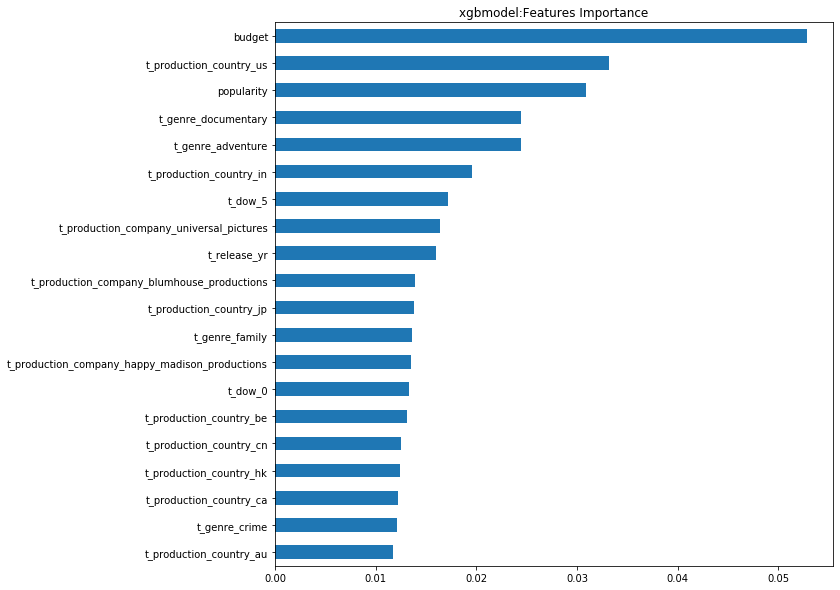

In [17]:
xgbmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "xgbmodel:Features Importance",
    figsize = (10,10))

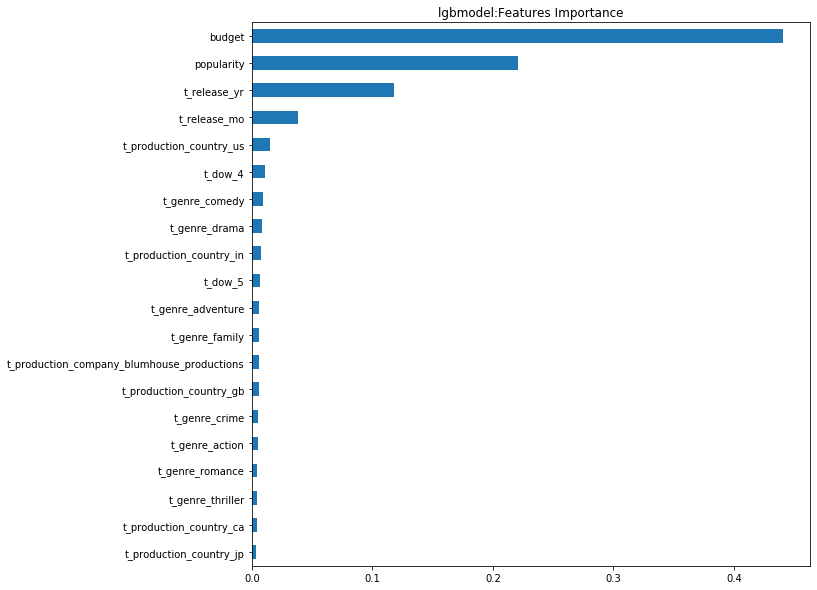

In [18]:
lgbmodel.FI.mean(axis=1).sort_values().tail(20).plot(
    kind="barh",
    title = "lgbmodel:Features Importance",
    figsize = (10,10))

In [19]:
def DotSum(A, B):
    return sum(a*b for a,b in zip(A, B))

train['mix1'] = DotSum((0.4, 0.2, 0.4),
                       (train['xgb'], train['cat'], train['lgb']))
test['mix1'] = DotSum((0.4, 0.2, 0.4),
                      (test['xgb'], test['cat'], test['lgb']))

train['mix2'] = DotSum((0.34, 0.33, 0.33),
                      (train['xgb'], train['cat'], train['lgb']))
test['mix2'] = DotSum((0.34, 0.33, 0.33),
                      (test['xgb'], test['cat'], test['lgb']))

for model_name in ('mix1', 'mix2', 'xgb', 'lgb', 'cat'):
    print("RMSE model {}: {}".format(model_name, Score(GetY(train), train[model_name])))

RMSE model mix1: 2.079219041214307
RMSE model mix2: 2.080088481637768
RMSE model xgb: 2.092975818504194
RMSE model lgb: 2.089248734703012
RMSE model cat: 2.120336642009709


# Submission

In [20]:
for model_name in ('mix1', 'mix2', 'xgb', 'lgb', 'cat'):
    print("Generating submission for ", model_name)
    test['revenue'] =  np.expm1(test[model_name])
    test[['id','revenue']].to_csv(
        'submissions/{}.csv'.format(model_name),
        index=False)
    print(test[['id','revenue']].head())

Generating submission for  mix1
     id       revenue
0  3001  7.379395e+06
1  3002  1.894493e+06
2  3003  8.513487e+06
3  3004  2.171766e+06
4  3005  1.311195e+06
Generating submission for  mix2
     id       revenue
0  3001  6.080278e+06
1  3002  1.805063e+06
2  3003  7.940542e+06
3  3004  2.396011e+06
4  3005  1.235326e+06
Generating submission for  xgb
     id       revenue
0  3001  8.210386e+06
1  3002  1.641087e+06
2  3003  9.266219e+06
3  3004  1.711000e+06
4  3005  1.200667e+06
Generating submission for  lgb
     id       revenue
0  3001  1.196527e+07
1  3002  2.521175e+06
2  3003  9.685370e+06
3  3004  2.031967e+06
4  3005  1.710779e+06
Generating submission for  cat
     id       revenue
0  3001  2.267416e+06
1  3002  1.425593e+06
2  3003  5.552643e+06
3  3004  3.996972e+06
4  3005  9.185503e+05
